# ITRODUCCIÓN

En este ejercicio, el objetivo es explorar y probar modelos capaces de generar texto en el estilo de Shakespeare, imitando su distintivo dialecto de época y su habilidad para escribir en verso y prosa. Utilizando un conjunto de datos compuesto por escritos de Shakespeare, se entrenaron previamente dos tipos de modelos de redes neuronales para generación de texto: uno basado en la predicción carácter a carácter y otro palabra a palabra.

El primer enfoque se centra en predecir el siguiente carácter dado un carácter o una secuencia de caracteres. Este modelo fue entrenado para que, en cada paso de tiempo, la entrada sea una secuencia de caracteres y la salida el siguiente carácter más probable. Esto aprovecha la capacidad de las redes neuronales recurrentes (RNN) para mantener un estado interno que depende de los elementos vistos anteriormente, permitiendo que el modelo utilice el contexto acumulado para generar texto.

El segundo enfoque adopta un método similar pero basado en palabras en lugar de caracteres. Aquí, el modelo analiza el texto palabra por palabra, aprendiendo las relaciones entre ellas para producir texto coherente en el estilo de Shakespeare.

En el dessarrollo, descargamos directamente los modelos preentrenados desde un drive para que puedan probarse. Además, el código que muestra el proceso de entrenamiento estará incluido, pero comentado, con en fin de no entrenar nuevament los modelos.

Finalmente, generamos conclusiones comparando ambos modelos.

# Preparación del entorno.

Descargamos el archivo Shakespeare.txt

In [1]:
import os
import requests

# URL del dataset
url = "https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt"
filename = "shakespeare.txt"

# Verificar si el archivo ya existe
if not os.path.exists(filename):
    print("Descargando dataset...")
    response = requests.get(url)
    with open(filename, "wb") as file:
        file.write(response.content)
    print(f"Dataset descargado como {filename}.")
else:
    print(f"El archivo {filename} ya existe en el directorio actual.")

Descargando dataset...
Dataset descargado como shakespeare.txt.


Importar librerías

In [2]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import gdown




Establecer GPU por defecto en caso de estar disponible.

In [3]:
# Configurar para que TensorFlow utilice la GPU por defecto
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Configurar para que TensorFlow asigne memoria dinámicamente
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Especificar la GPU por defecto
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Manejar error
        print(e)

1 Physical GPUs, 1 Logical GPUs


Descargamos los modelos

In [4]:

# Enlaces directos de los archivos
file_1_url = "https://drive.google.com/uc?id=1_-EktYtzvChdSY_C-vLVr9g6q-XhgCTw"
file_2_url = "https://drive.google.com/uc?id=10GSHu8qI6FAlISUFflIOMC3EIsDvyIfn"

# Nombres de los archivos en el directorio /content con la extensión .keras
file_1_path = "/content/best_model_loss_palabras.keras"
file_2_path = "/content/best_model_loss_caracteres.keras"


# Descargar los archivos
print("Descargando archivos...")
gdown.download(file_1_url, file_1_path, quiet=False)
gdown.download(file_2_url, file_2_path, quiet=False)

print("Archivos descargados y guardados en /content con los nombres:")
print(f"- {file_1_path}")
print(f"- {file_2_path}")


Descargando archivos...


Downloading...
From (original): https://drive.google.com/uc?id=1_-EktYtzvChdSY_C-vLVr9g6q-XhgCTw
From (redirected): https://drive.google.com/uc?id=1_-EktYtzvChdSY_C-vLVr9g6q-XhgCTw&confirm=t&uuid=cf815fca-4a20-4f03-b26a-d541727e816f
To: /content/best_model_loss_palabras.keras
100%|██████████| 442M/442M [00:07<00:00, 57.3MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=10GSHu8qI6FAlISUFflIOMC3EIsDvyIfn
From (redirected): https://drive.google.com/uc?id=10GSHu8qI6FAlISUFflIOMC3EIsDvyIfn&confirm=t&uuid=987f0336-debf-4096-921d-3687f13065c9
To: /content/best_model_loss_caracteres.keras
100%|██████████| 48.3M/48.3M [00:00<00:00, 263MB/s]

Archivos descargados y guardados en /content con los nombres:
- /content/best_model_loss_palabras.keras
- /content/best_model_loss_caracteres.keras


# 1 - Primer enfoque: modelo de predicción caracter a caracter


## Carga del dataset y descripción de los datos

In [5]:
# Read, then decode for py2 compat.
text = open("shakespeare.txt", 'rb').read().decode(encoding='utf-8')
# length of text is the number of characters in it
print(f'Length of text: {len(text)} characters')

Length of text: 1115394 characters


In [6]:
# Take a look at the first 500 characters in text
print(text[:500])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor


In [7]:
# The unique characters in the file
vocab = sorted(set(text)) # These are caracters tokens from texts
print(f'{len(vocab)} unique characters')

65 unique characters


In [8]:
# Let's see the characters
print(vocab)

['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


Como puede apreciarse, el archivo completo contiene 1115394 caractéres, de los cuales, únicos son 65.

## Preprocesamiento

### Vectorización del texto

Convertimos el texto a una representación numérica.

La capa `tf.keras.layers.StringLookup` permite convertir cada caracter en un ID numérico. Solo necesita que el texto este separado primero en tokens. La variable 'vocab', que es el diccionario, lo está.


Ahora creamos la capa `tf.keras.layers.StringLookup`:

In [9]:
ids_from_chars = tf.keras.layers.StringLookup(
    vocabulary=list(vocab), mask_token=None)

Es importante invertir esta representacion y recuperar texto legible desde estos IDs. Para esto podemos usar `tf.keras.layers.StringLookup(..., invert=True)`.

Nota: Aquí, en lugar de pasar el vocabulario original generado con `sorted(set(text))`, usamos el método `get_vocabulary()` de la capa `tf.keras.layers.StringLookup` para que los tokens `[UNK]` se configuren de la misma manera.

In [10]:
chars_from_ids = tf.keras.layers.StringLookup(
    vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None)

Esta capa recupera los caracteres desde los vectores de IDs y los retorna como un `tf.RaggedTensor` de caracteres. La siguiente función convierte un tensor de IDs de caracteres en texto legible, uniéndolos como una cadena de caracteres.

In [11]:
def text_from_ids(ids):
  return tf.strings.reduce_join(chars_from_ids(ids), axis=-1)

### Crear los ejemplos de entrenamiento

Dividimos el texto en secuencias de ejemplo. Cada secuencia de entrada contendrá `seq_length` caracteres del texto.

Para cada secuencia de entrada, los targets correspondientes contienen la misma longitud de texto, excepto que se desplazan un carácter hacia la derecha.

Así que divida el texto en fragmentos de `seq_length+1`. Por ejemplo, digamos que `seq_length` es 3 y nuestro texto es "Hola". La secuencia de entrada sería "Hol" y la secuencia target "ola".

Para hacer esto, usamos la función `tf.data.Dataset.from_tensor_slices` para convertir el vector de texto en una secuencia de índices de caracteres.

Dividimos el texto en fragmentos de longitud fija (seq_length+1) para crear los ejemplos de entrenamiento.

In [12]:
all_ids = ids_from_chars(tf.strings.unicode_split(text, 'UTF-8'))
all_ids

<tf.Tensor: shape=(1115394,), dtype=int64, numpy=array([19, 48, 57, ..., 46,  9,  1])>

In [13]:
ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)

In [14]:
for ids in ids_dataset.take(15):
    print(chars_from_ids(ids).numpy().decode('utf-8'))

F
i
r
s
t
 
C
i
t
i
z
e
n
:




El método `batch` nos permite convertir fácilmente estos caracteres individuales en secuencias del tamaño deseado. Se agrupan los IDs en secuencias de longitud seq_length+1. El +1 es para que cada secuencia tenga tanto la entrada como el objetivo.

In [15]:
seq_length = 100

sequences = ids_dataset.batch(seq_length+1, drop_remainder=True)

for seq in sequences.take(1):
  print(chars_from_ids(seq))

tf.Tensor(
[b'F' b'i' b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':'
 b'\n' b'B' b'e' b'f' b'o' b'r' b'e' b' ' b'w' b'e' b' ' b'p' b'r' b'o'
 b'c' b'e' b'e' b'd' b' ' b'a' b'n' b'y' b' ' b'f' b'u' b'r' b't' b'h'
 b'e' b'r' b',' b' ' b'h' b'e' b'a' b'r' b' ' b'm' b'e' b' ' b's' b'p'
 b'e' b'a' b'k' b'.' b'\n' b'\n' b'A' b'l' b'l' b':' b'\n' b'S' b'p' b'e'
 b'a' b'k' b',' b' ' b's' b'p' b'e' b'a' b'k' b'.' b'\n' b'\n' b'F' b'i'
 b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':' b'\n' b'Y'
 b'o' b'u' b' '], shape=(101,), dtype=string)


Es más fácil ver lo que esta haciendo si unimos de vuelta los tokens en texto. En lo siguiente, convertimos las secuencias de vuelta a texto para verificar que las divisiones se realizaron correctamente.

In [16]:
for seq in sequences.take(5):
  print(text_from_ids(seq).numpy())

b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '
b'are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you k'
b"now Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us ki"
b"ll him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be d"
b'one: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citi'


Para el entrenamiento, necesitaremos un conjunto de datos de pares `(input, label)`. Donde `input` y
`label` son secuencias. En cada timestep, la entrada es el carácter actual y la etiqueta es el siguiente carácter.

La siguiente función que toma una secuencia como entrada, la duplica y la desplaza para alinear la entrada y la etiqueta para cada timestep:

In [17]:
def split_input_target(sequence):
    input_text = sequence[:-1]
    target_text = sequence[1:]
    return input_text, target_text

Esta función divide la secuencia en dos: input_text (todos los caracteres excepto el último) y target_text (todos excepto el primero).

La siguiente función aplica la función split_input_target a todas las secuencias en el dataset.

In [18]:
dataset = sequences.map(split_input_target)

In [19]:
for input_example, target_example in dataset.take(1):
    print("Input :", text_from_ids(input_example).numpy())
    print("Target:", text_from_ids(target_example).numpy())

Input : b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'
Target: b'irst Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '


## Batches de entrenamiento

Usamos `tf.data` para dividir el texto en secuencias manejables. Pero antes de introducir estos datos en el modelo, es necesario mezclarlos y batchearlos.

In [20]:
# Batch size
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(64, 100), dtype=tf.int64, name=None), TensorSpec(shape=(64, 100), dtype=tf.int64, name=None))>

## Construcción del modelo

En esta sección, construimos el modelo utilizando la API tf.keras.Sequential, que permite apilar capas de forma secuencial para definir la arquitectura de una red neuronal.

Este modelo tiene tres capas:

* `tf.keras.layers.Embedding`: La capa de entrada. Una lookup table entrenable que asignará cada ID de carácter a un vector con dimensiones `embedding_dim`;
* `tf.keras.layers.GRU`: una capa recurrente GRU de tamaño `units=rnn_units`.
* `tf.keras.layers.Dense`: La capa de salida, con salidas `vocab_size`. Genera un logit para cada carácter del vocabulario. Estas son las probabilidades de cada caracter según el modelo.

In [21]:
# Length of the vocabulary in StringLookup Layer
vocab_size = len(ids_from_chars.get_vocabulary())

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

In [22]:
# Crear el modelo utilizando tf.keras.Sequential
model = tf.keras.Sequential([
    # Capa de Embedding con dimensión de entrada especificada
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=None),

    # Capa RNN (GRU) para procesar las secuencias
    tf.keras.layers.GRU(units=rnn_units, return_sequences=True),

    # Capa Dense para mapear a los valores del vocabulario
    tf.keras.layers.Dense(units=vocab_size)
])



Por cada caracter el modelo calcula su embedding, corre la GRU un timestep con el embedding como entrada y aplica la capa densa para generar los logits prediciendo la probabilidades del siguiente caracter.



## Probar el modelo

Ejecutamos el modelo para ver que se comporta como se esperaba.

Primero verificamos la shape de salida:

In [23]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")


(64, 100, 66) # (batch_size, sequence_length, vocab_size)


En el ejemplo anterior, la longitud de la secuencia de la entrada es `100`, pero el modelo se puede ejecutar con entradas de cualquier longitud:

In [24]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (64, 100, 256)              │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (64, 100, 1024)             │       3,938,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (64, 100, 66)               │          67,650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,022,850 (15.35 MB)

 Trainable params: 4,022,850 (15.35 MB)

 Non-trainable params: 0 (0.00 B)

Para obtener predicciones reales del modelo, se deben tomar muestras de la distribución de salida para obtener índices de caracteres reales. Esta distribución está definida por los logits sobre el vocabulario de los caracteres.

Nota: Es importante tomar una muestra de esta distribución, ya que tomar el _argmax_ de la distribución puede fácilmente hacer que el modelo se atasque en un bucle.

Tomando como ejemplo el primero del batch:

In [25]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices, axis=-1).numpy()

Esto nos da para cada timestep una predicción del siguiente índice de caracteres:

In [26]:
sampled_indices

array([25, 33, 43,  3, 53, 17,  2, 38, 41, 21,  0, 57, 52, 10, 13, 46, 59,
       15, 40, 42, 55, 12, 55, 53, 22, 11, 63, 13,  1, 12, 61, 21,  5, 59,
       11, 48, 57, 52, 64, 16, 58, 31, 22, 64, 41, 65, 55, 29,  4, 56,  8,
        5, 41, 54, 26, 61, 53, 17,  1, 39, 19, 13, 29, 41, 24, 47, 36, 26,
       41, 35, 42, 61, 41, 42, 63, 39, 62, 25, 21, 43, 63, 30,  4, 46, 14,
        5, 48, 45, 48,  4, 10, 52, 37, 20, 28, 55, 47, 49, 49, 37])

Por ultimo los decodificamos para ver el texto predicho por este modelo no entrenado:

In [27]:
print("Input:\n", text_from_ids(input_example_batch[0]).numpy())
print()
print("Next Char Predictions:\n", text_from_ids(sampled_indices).numpy())

Input:
 b"ughter fairer than she is,\nShe may more suitors have and me for one.\nFair Leda's daughter had a thou"

Next Char Predictions:
 b'LTd!nD YbH[UNK]rm3?gtBacp;pnI:x?\n;vH&t:irmyCsRIybzpP$q-&boMvnD\nZF?PbKhWMbVcvbcxZwLHdxQ$gA&ifi$3mXGOphjjX'


## Entrenamiento del modelo

El problema puede tratarse como un problema de clasificación estándar. Dado el estado RNN anterior y la entrada en este timestep, predice la clase del siguiente caracter.

### Agregamos un optimizador y una funcion costo

La función de pérdida estándar `tf.keras.losses.sparse_categorical_crossentropy` funciona en este caso porque se aplica en la última dimensión de las predicciones.

Debido a que su modelo devuelve logits, necesita configurar el indicador `from_logits`.

In [28]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

In [29]:
example_batch_mean_loss = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("Mean loss:        ", example_batch_mean_loss)

Prediction shape:  (64, 100, 66)  # (batch_size, sequence_length, vocab_size)
Mean loss:         tf.Tensor(4.1905484, shape=(), dtype=float32)


Un modelo recién inicializado no debería estar demasiado seguro de sí mismo, todos los logits de salida deberían tener magnitudes similares. Para confirmar esto, puede comprobar que la exponencial del costo medio es aproximadamente igual al tamaño del vocabulario. Una pérdida mucho mayor significa que el modelo está seguro de sus respuestas incorrectas y está mal inicializado:

In [30]:
tf.exp(example_batch_mean_loss).numpy()

66.05901

Compilamos el modelo con `tf.keras.Model.compile` indicando el optimizador y la funcion costo:

In [31]:
model.compile(
    optimizer='adam',
    loss=loss,
    metrics=['accuracy'])

### Checkpoints del modelo

Usamos el callback `tf.keras.callbacks.ModelCheckpoint` para que se guarden checkpoints del modelo durante el entrenamiento.

In [32]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)  # Create the directory if it doesn't exist

# Prefix for the checkpoint file names
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}.weights.h5")

# Callback to save model weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True  # Save only the model's weights
)

### Ejecución del entrenamiento

Utilizamos 50 épocas para entrenar el modelo. En Colab, configure el tiempo de ejecución en GPU para un entrenamiento más rápido.

In [33]:
EPOCHS = 50

Configuramos el fit para que vaya guardando el mejor modelo en base al loss. Además, esta es la parte que quedará comentada en el código para cuando usted ejectue todo el código, no vuelva a entrenar, sino recuepre el modelo que ya hemos entrenado previamente.

In [34]:
'''
# Guardar el mejor modelo basado en la pérdida (loss)
loss_model_filepath = 'best_model_loss_caracteres.keras'

loss_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=loss_model_filepath,  # Guardar el modelo basado en loss
    monitor='loss',                # Monitorear pérdida
    save_best_only=True,           # Guardar solo el mejor modelo
    save_weights_only=False,       # Guardar el modelo completo
    verbose=1                      # Mostrar mensajes al guardar
)

# Entrenar el modelo con los callbacks ajustados
history = model.fit(
    dataset,                      # Datos de entrenamiento
    epochs=EPOCHS,                # Número de épocas
    callbacks=[loss_callback, checkpoint_callback]  # Usar ambos callbacks
)

'''

"\n# Guardar el mejor modelo basado en la pérdida (loss)\nloss_model_filepath = 'best_model_loss_caracteres.keras'\n\nloss_callback = tf.keras.callbacks.ModelCheckpoint(\n    filepath=loss_model_filepath,  # Guardar el modelo basado en loss\n    monitor='loss',                # Monitorear pérdida\n    save_best_only=True,           # Guardar solo el mejor modelo\n    save_weights_only=False,       # Guardar el modelo completo\n    verbose=1                      # Mostrar mensajes al guardar\n)\n\n# Entrenar el modelo con los callbacks ajustados\nhistory = model.fit(\n    dataset,                      # Datos de entrenamiento\n    epochs=EPOCHS,                # Número de épocas\n    callbacks=[loss_callback, checkpoint_callback]  # Usar ambos callbacks\n)\n\n"

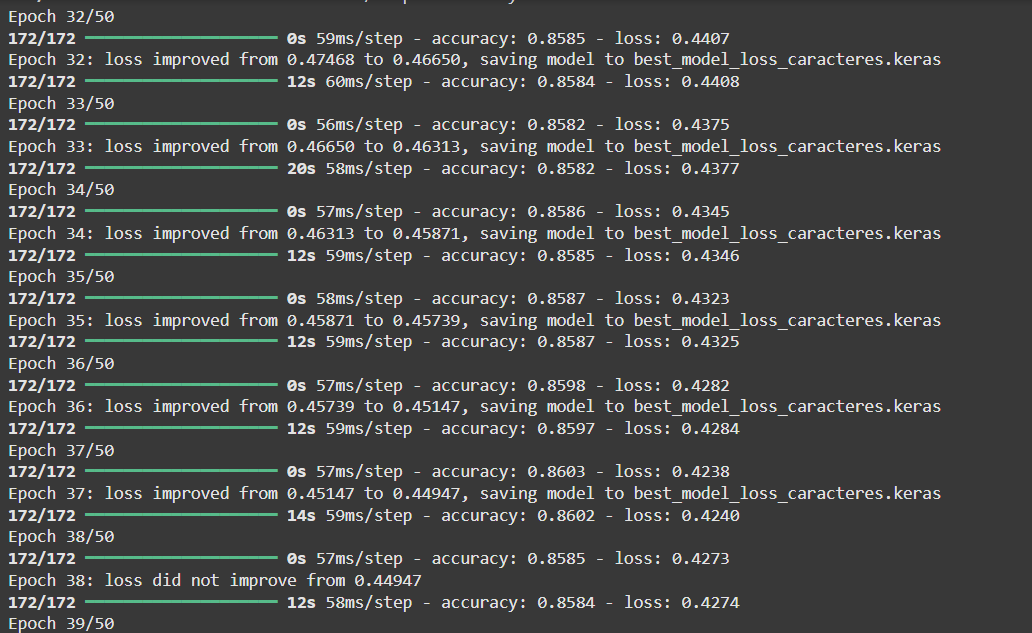

In [35]:
'''
acc = history.history['accuracy']
loss = history.history['loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 4))

# Gráfico de Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.legend(loc='lower right')
plt.title('Training Accuracy')

# Gráfico de Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.legend(loc='upper right')
plt.title('Training Loss')

plt.show()
'''

"\nacc = history.history['accuracy']\nloss = history.history['loss']\n\nepochs_range = range(EPOCHS)\n\nplt.figure(figsize=(8, 4))\n\n# Gráfico de Accuracy\nplt.subplot(1, 2, 1)\nplt.plot(epochs_range, acc, label='Training Accuracy')\nplt.legend(loc='lower right')\nplt.title('Training Accuracy')\n\n# Gráfico de Loss\nplt.subplot(1, 2, 2)\nplt.plot(epochs_range, loss, label='Training Loss')\nplt.legend(loc='upper right')\nplt.title('Training Loss')\n\nplt.show()\n"

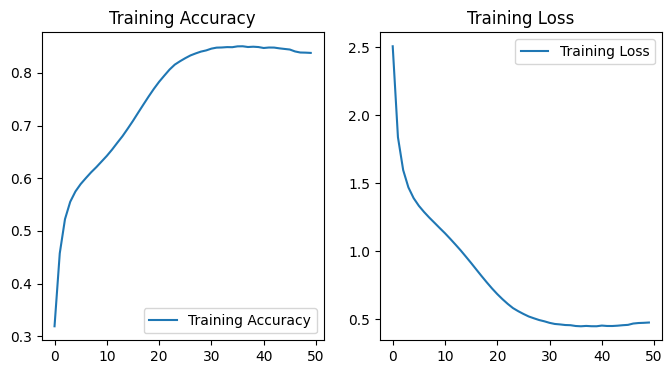

In [36]:
# Load the best model
best_model_caracteres = load_model('best_model_loss_caracteres.keras')
print("Best model loaded successfully!")

Best model loaded successfully!


## Generación de texto

El código genera texto de manera iterativa utilizando un modelo secuencial entrenado. Comienza con una cadena inicial (start_string), que convierte en índices numéricos para alimentar al modelo. A partir de ahí, predice el siguiente carácter más probable en cada paso y retroalimenta esta predicción como entrada para continuar generando texto.

La aleatoriedad de las predicciones se ajusta mediante un parámetro llamado temperature, que controla si el texto generado será más creativo o más predecible. El proceso se repite hasta alcanzar el número deseado de caracteres, y al final, las predicciones se ensamblan en un texto completo que incluye la cadena inicial.

Este enfoque permite crear texto continuo y coherente basado en el estilo aprendido por el modelo durante el entrenamiento.

Lo siguiente hace una predicción de un solo paso:

In [37]:
# Reutilizando text_from_ids en la generación
def generate_text_caracteres(model, start_string, num_generate=500, temperature=1.0):
    """
    Generar texto basado en un modelo secuencial.

    Args:
    - model: El modelo entrenado y cargado.
    - start_string: Cadena inicial para comenzar la generación de texto.
    - num_generate: Número de caracteres a generar.
    - temperature: Controla la aleatoriedad de las predicciones (más alto, más aleatorio).

    Returns:
    - Texto generado.
    """
    # Convertir la cadena inicial a índices
    input_eval = tf.strings.unicode_split(start_string, 'UTF-8')
    input_eval = ids_from_chars(input_eval)
    input_eval = tf.expand_dims(input_eval, 0)  # Agregar dimensión de lote

    # Lista para almacenar los caracteres generados
    text_generated = []

    # Generar caracteres
    for _ in range(num_generate):
        # Obtener predicción
        predictions = model(input_eval)
        predictions = predictions[:, -1, :] / temperature  # Usar la última predicción
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1, 0].numpy()

        # Convertir el índice a un carácter
        next_char = chars_from_ids([predicted_id]).numpy()[0].decode('utf-8')

        # Agregar el carácter generado a la lista
        text_generated.append(next_char)

        # Usar el carácter generado como entrada para la siguiente iteración
        input_eval = tf.expand_dims([predicted_id], 0)

    # Convertir índices generados a texto utilizando text_from_ids
    return start_string + ''.join(text_generated)



In [38]:
# Usar la función para generar texto
start_text = "To die: to sleep; To sleep:"  # Cadena inicial
generated_text = generate_text_caracteres(best_model_caracteres, start_text, num_generate=20, temperature=0.3)
print("Texto generado:\n", generated_text)


Texto generado:
 To die: to sleep; To sleep: the the the ithe av


Como se puede apreciar, el modelo genera texto pero de un modo no adecuado debido a que no tiene sentido alguno el texto producido.

# 2 - Segundo enfoque: modelo de predicción palabra a palabra

En esta segunda sección, saltearemos las explicaciones que ya fueron expresadas en la seección anterior para evitar redundancia. Sólo haremos las menciones que consideremos pertinente dado que si bien el problema resulta similiar en terminos generales, el enfoque ahora es otro: predicción palabra a palabra.

In [39]:
# Leer el texto
text = open("shakespeare.txt", 'rb').read().decode(encoding='utf-8')

# Dividir el texto en palabras
words = text.split()  # División por espacio
print(f'Número total de palabras: {len(words)}')

# Crear una capa StringLookup para manejar el vocabulario
lookup_layer = tf.keras.layers.StringLookup(vocabulary=sorted(set(words)), mask_token=None)

# Obtener el vocabulario directamente desde la capa
vocab = lookup_layer.get_vocabulary()  # Ya ordenado
print(f'{len(vocab)} palabras únicas')
print("Primeras palabras del vocabulario:", vocab[:10])

# Codificar el texto como índices
encoded_text = lookup_layer(words)  # Convierte palabras a índices
print(f"Primeros 10 índices codificados: {encoded_text[:10].numpy()}")

# Crear una capa inversa para decodificar índices a palabras
reverse_lookup_layer = tf.keras.layers.StringLookup(
    vocabulary=lookup_layer.get_vocabulary(), invert=True
)

# Ver las primeras palabras decodificadas
decoded_words = reverse_lookup_layer(encoded_text[:10])
print(f"Primeras palabras decodificadas: {[w.numpy().decode('utf-8') for w in decoded_words]}")

# Crear un Dataset a partir de los índices
ids_dataset = tf.data.Dataset.from_tensor_slices(encoded_text)

# Verificar las primeras palabras como índices y decodificarlas
print("\nPrimeras palabras del Dataset:")
for ids in ids_dataset.take(10):
    print(reverse_lookup_layer(ids).numpy().decode('utf-8'))  # Decodificar índice a palabra

# Longitud de las secuencias
seq_length = 20

# Dividir el Dataset en secuencias
sequences = ids_dataset.batch(seq_length + 1, drop_remainder=True)

# Imprimir secuencias decodificadas
print("\nSecuencias de palabras decodificadas:")
for seq in sequences.take(5):
    decoded_sequence = reverse_lookup_layer(seq)
    print(' '.join([word.numpy().decode('utf-8') for word in decoded_sequence]))


Número total de palabras: 202651
25671 palabras únicas
Primeras palabras del vocabulario: ['[UNK]', '&C:', '&c.', "'", "'?", "'A", "'Alas,", "'Alas,'", "'Alla", "'An"]
Primeros 10 índices codificados: [ 1581   993   638 24644 18489  5160 11878 12901 15682 21345]
Primeras palabras decodificadas: ['First', 'Citizen:', 'Before', 'we', 'proceed', 'any', 'further,', 'hear', 'me', 'speak.']

Primeras palabras del Dataset:
First
Citizen:
Before
we
proceed
any
further,
hear
me
speak.

Secuencias de palabras decodificadas:
First Citizen: Before we proceed any further, hear me speak. All: Speak, speak. First Citizen: You are all resolved rather to
die than to famish? All: Resolved. resolved. First Citizen: First, you know Caius Marcius is chief enemy to the people. All:
We know't, we know't. First Citizen: Let us kill him, and we'll have corn at our own price. Is't a verdict?
All: No more talking on't; let it be done: away, away! Second Citizen: One word, good citizens. First Citizen: We are
acc

In [40]:
# Let's see unique words
print(vocab)

['[UNK]', '&C:', '&c.', "'", "'?", "'A", "'Alas,", "'Alas,'", "'Alla", "'An", "'Ay", "'Ay,", "'Ay,'", "'Ay.'", "'Be", "'Beseech", "'Bless", "'Bove", "'Brutus!'", "'By", "'Charge", "'Charge!", "'Citizens!'", "'Clarence", "'Come", "'Come,", "'Commend", "'Con", "'Content'", "'Coriolanus!'", "'Courage!'", "'Courage,", "'Cucullus", "'Dear", "'Death.'", "'Deny", "'Do", "'Fair", "'Faith,", "'Farewell:'", "'Fine;'", "'Fore", "'Forgive", "'Frets,", "'G'", "'Gainst", "'Go", "'God", "'Good", "'Have", "'He", "'Heart's", "'Hell", "'Hic", "'Hold,", "'I", "'I'", "'I';", "'I'll", "'I,'", "'I.'", "'Is", "'It", "'Jack,", "'Jesu", "'King", "'Lo,", "'Madam,'", "'Margaret.'", "'My", "'Now", "'O", "'O,", "'Pardon'", "'Patricians!'", "'Peace,", "'Priami,'", "'Proud,'", "'Redime", "'Remember", "'Retire,'", "'Rise;'", "'Romeo", "'Saint", "'Save", "'Scape", "'Shall'!", "'She", "'Sicilia", "'Sicinius!'", "'Sigeia", "'Signior", "'Simois,'", "'Sir,", "'Sirrah,", "'Small", "'Stay,", "'Stay:", "'Tear", "'Tell", "'Th

La primera diferencia que puede apreciarse respecto del modelo anterior es que si bien el número total de elementos disminuyó, el vocabulario aumento.

Fijémonos que, además, el modo de contrucción del dataset es diferente al anterior. Al utilizar text.split() "perdimos" el salto de línea y el espacio como parte del vocabulario, siendo el espacio lo que divide a las palabras. Por otra parte, los signos de puntuación quedaron incorporados en las palabras. Esto hace que el vocabularios sea más grande porque, como puede apreciarse, la seguientes palabras son todas distintas: "'Ay", "'Ay,", "'Ay,'", "'Ay.'". Consideramos que tiene sentido hacer esto dado que los signos de puntuación aportan un significado lingüístico a las palabras que las diferencia, incluso pueden cambiar todo el sentido de una frase, como el ejemplo de Sarmiento: "El maestro dice: el inspector es un ignorante." y "El maestro, dice el inspector, es un ignorante." Sin embargo, esto conlleva a que el modelo sea más grande y menos eficiente su entrenamiento porque aumenta el vocabulario. También, consideramos que el modelo aprendería el significado de los signos de puntuación de manera independiente de las palabras en particular. Opatamos contruir el vocabulario y el modelo de este modo por curiocidad de apreciar cómo se comportaría en la predicción.

Por otra parte, a diferencia del dataset caracter a carecter, la entrada del modelo parte de un objeto lista que contiene las palabras str en el mismo orden que aparecen en el texto. Recordemos que el modelo anterior partía de las cadenas str del texto.

## Preprocesamiento

### Vectorizacion del texto




In [41]:
# Imprimir secuencias palabra por palabra (similar al formato de caracteres)
for seq in sequences.take(5):
    print(seq)

tf.Tensor(
[ 1581   993   638 24644 18489  5160 11878 12901 15682 21345   403  3654
 21345  1581   993  4414  5275  4913 19437 19000 23096], shape=(21,), dtype=int64)
tf.Tensor(
[ 9345 22642 23096 10810   403  3268 19439  1581   993  1582 25597 14428
   864  2512 14033  7440 10308 23096 22671 17709   403], shape=(21,), dtype=int64)
tf.Tensor(
[ 4209 14432 24644 14433  1581   993  2363 24057 14261 13190  5090 24645
 12823  8242  5446 17226 17328 18396  2150  4429 24210], shape=(21,), dtype=int64)
tf.Tensor(
[  403  2771 16198 22447 17082 14791 14070  5788  9734  5547  5545  3459
   993  2858 25327 12251  7547  1581   993  4209  5275], shape=(21,), dtype=int64)
tf.Tensor(
[ 4576 18127  7546 22671 17587 12256  4245  5514 22220 17074 25416 19229
 24061 13585 22763 25416 25576 24057  6920 22671 22168], shape=(21,), dtype=int64)


### Crear los ejemplos de entrenamiento



In [42]:
def split_input_target(sequence):
    """
    Divide una secuencia en entrada y objetivo.

    Args:
    - sequence: Secuencia de palabras como índices.

    Returns:
    - input_seq: Secuencia de entrada (todos menos el último índice).
    - target_seq: Secuencia objetivo (todos menos el primer índice).
    """
    input_seq = sequence[:-1]  # Todos menos el último
    target_seq = sequence[1:]  # Todos menos el primero
    return input_seq, target_seq


In [43]:
dataset = sequences.map(split_input_target)

In [44]:
# Aplicar la función para dividir las secuencias en entrada y objetivo
def split_input_target(sequence):
    input_seq = sequence[:-1]
    target_seq = sequence[1:]
    return input_seq, target_seq

dataset = sequences.map(split_input_target)

# Imprimir un ejemplo
for input_example, target_example in dataset.take(1):
    # Decodificar índices a palabras para visualizar el contenido
    input_words = [reverse_lookup_layer(idx).numpy().decode('utf-8') for idx in input_example.numpy()]
    target_words = [reverse_lookup_layer(idx).numpy().decode('utf-8') for idx in target_example.numpy()]

    print("Input :", input_words)
    print("Target:", target_words)


Input : ['First', 'Citizen:', 'Before', 'we', 'proceed', 'any', 'further,', 'hear', 'me', 'speak.', 'All:', 'Speak,', 'speak.', 'First', 'Citizen:', 'You', 'are', 'all', 'resolved', 'rather']
Target: ['Citizen:', 'Before', 'we', 'proceed', 'any', 'further,', 'hear', 'me', 'speak.', 'All:', 'Speak,', 'speak.', 'First', 'Citizen:', 'You', 'are', 'all', 'resolved', 'rather', 'to']


### Batches de entrenamiento



In [45]:
# Tamaño del batch
BATCH_SIZE = 64

# Tamaño del buffer para el shuffle
BUFFER_SIZE = 10000

# Crear un nuevo dataset adaptado
dataset = (
    sequences  # Dataset con las secuencias creadas previamente
    .map(split_input_target)  # Dividir en entrada y objetivo
    .shuffle(BUFFER_SIZE)  # Mezclar las secuencias
    .batch(BATCH_SIZE, drop_remainder=True)  # Agrupar en lotes
    .prefetch(tf.data.experimental.AUTOTUNE)  # Optimizar el acceso a datos
)

# Imprimir un ejemplo para verificar
for input_example_batch, target_example_batch in dataset.take(1):
    # Decodificar índices a palabras utilizando reverse_lookup_layer
    input_words = [reverse_lookup_layer(idx).numpy().decode('utf-8') for idx in input_example_batch.numpy()[0]]
    target_words = [reverse_lookup_layer(idx).numpy().decode('utf-8') for idx in target_example_batch.numpy()[0]]

    print("Ejemplo de entrada:")
    print(input_words)
    print("\nEjemplo de objetivo:")
    print(target_words)


Ejemplo de entrada:
['the', 'eldest', 'sister.', 'This', 'liberty', 'is', 'all', 'that', 'I', 'request,', 'That,', 'upon', 'knowledge', 'of', 'my', 'parentage,', 'I', 'may', 'have', 'welcome']

Ejemplo de objetivo:
['eldest', 'sister.', 'This', 'liberty', 'is', 'all', 'that', 'I', 'request,', 'That,', 'upon', 'knowledge', 'of', 'my', 'parentage,', 'I', 'may', 'have', 'welcome', "'mongst"]


## Construcción del modelo

In [46]:
# Longitud del vocabulario
vocab_size = lookup_layer.vocabulary_size()  # Obtener el tamaño del vocabulario desde StringLookup

# Dimensión de la capa Embedding
embedding_dim = 256  # Cada palabra se mapeará a un vector de esta dimensión

# Número de unidades RNN
rnn_units = 1024  # Número de unidades en la capa GRU o LSTM

print(f"Tamaño del vocabulario: {vocab_size}")
print(f"Dimensión de Embedding: {embedding_dim}")
print(f"Unidades RNN: {rnn_units}")



Tamaño del vocabulario: 25671
Dimensión de Embedding: 256
Unidades RNN: 1024


In [47]:
# Crear el modelo para palabras
model = tf.keras.Sequential([
    # Capa de Embedding: vocab_size ahora es el tamaño del vocabulario de palabras
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim),

    # Capa GRU: procesar secuencias de palabras
    tf.keras.layers.GRU(units=rnn_units, return_sequences=True),

    # Capa Dense: salida de probabilidad para cada palabra en el vocabulario
    tf.keras.layers.Dense(units=vocab_size)
])



## Probar el modelo

Ejecutamos el modelo para ver que se comporta como se esperaba.

Primero verificamos la shape de salida:

In [48]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")


(64, 20, 25671) # (batch_size, sequence_length, vocab_size)


En modelo de predicción caracter a caracter, la longitud de la secuencia de la entrada era de 100, mientras que en este optamos por reducirla a 20:

In [49]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (64, 20, 256)               │       6,571,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (64, 20, 1024)              │       3,938,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (64, 20, 25671)             │      26,312,775 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 36,822,855 (140.47 MB)

 Trainable params: 36,822,855 (140.47 MB)

 Non-trainable params: 0 (0.00 B)

En el summary del modelo puede apreciarse como varía la dimensión respecto del anterior. Más allá que el modo de construir el vocabulario incide en el tamaño del modelo, un modelo a partir de palabras obligatoriamente será más grande que uno de caracteres por el solo hecho de que existen más palabras que caracteres en la escritura de una lengua.

In [50]:
# Tomar las predicciones del primer ejemplo en el batch
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices, axis=-1).numpy()

# Mostrar la entrada y las predicciones de la siguiente palabra
input_example_words = [reverse_lookup_layer(idx).numpy().decode('utf-8') for idx in input_example_batch[0].numpy()]
predicted_words = [reverse_lookup_layer(idx).numpy().decode('utf-8') for idx in sampled_indices]

print("Input (Palabras):\n", " ".join(input_example_words))
print("\nNext Word Predictions (Palabras):\n", " ".join(predicted_words))


Input (Palabras):
 see, see what showers arise, Blown with the windy tempest of my heart, Upon thy words, that kill mine eye

Next Word Predictions (Palabras):
 loved. contrive abroad? fee, sucking money. stock-fishes. tongue, therefore spiriting delivery. Here's meaning. battle, tartness Has rely well-a-day, impatient. politicly


In [51]:
sampled_indices

array([15226,  8182,  4502, 10993, 22065, 16159, 21757, 23184, 22738,
       21431,  9076,  1965, 15717,  5762, 22479,  1899, 19237, 24788,
       13650, 18113])

## Entrenamiento del modelo

### Agregamos un optimizador y una funcion costo

In [52]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

In [53]:
example_batch_mean_loss = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("Mean loss:        ", example_batch_mean_loss)

Prediction shape:  (64, 20, 25671)  # (batch_size, sequence_length, vocab_size)
Mean loss:         tf.Tensor(10.153121, shape=(), dtype=float32)


In [54]:
tf.exp(example_batch_mean_loss).numpy()

25671.096

Compilamos el modelo con `tf.keras.Model.compile` indicando el optimizador y la funcion costo:

In [55]:
model.compile(
    optimizer='adam',
    loss=loss,
    metrics=['accuracy'])

### Checkpoints del modelo

In [56]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints_palabras'
os.makedirs(checkpoint_dir, exist_ok=True)  # Create the directory if it doesn't exist

# Prefix for the checkpoint file names
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}.weights.h5")

# Callback to save model weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True  # Save only the model's weights
)

### Ejecucion del entrenamiento

In [57]:
EPOCHS = 50

In [58]:
'''
# Guardar el mejor modelo basado en la pérdida (loss)
loss_model_filepath = 'best_model_loss_palabras.keras'

loss_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=loss_model_filepath,  # Guardar el modelo basado en loss
    monitor='loss',                # Monitorear pérdida
    save_best_only=True,           # Guardar solo el mejor modelo
    save_weights_only=False,       # Guardar el modelo completo
    verbose=1                      # Mostrar mensajes al guardar
)

# Entrenar el modelo con los callbacks ajustados
history = model.fit(
    dataset,                      # Datos de entrenamiento
    epochs=EPOCHS,                # Número de épocas
    callbacks=[loss_callback, checkpoint_callback]  # Usar ambos callbacks
)

'''

"\n# Guardar el mejor modelo basado en la pérdida (loss)\nloss_model_filepath = 'best_model_loss_palabras.keras'\n\nloss_callback = tf.keras.callbacks.ModelCheckpoint(\n    filepath=loss_model_filepath,  # Guardar el modelo basado en loss\n    monitor='loss',                # Monitorear pérdida\n    save_best_only=True,           # Guardar solo el mejor modelo\n    save_weights_only=False,       # Guardar el modelo completo\n    verbose=1                      # Mostrar mensajes al guardar\n)\n\n# Entrenar el modelo con los callbacks ajustados\nhistory = model.fit(\n    dataset,                      # Datos de entrenamiento\n    epochs=EPOCHS,                # Número de épocas\n    callbacks=[loss_callback, checkpoint_callback]  # Usar ambos callbacks\n)\n\n"

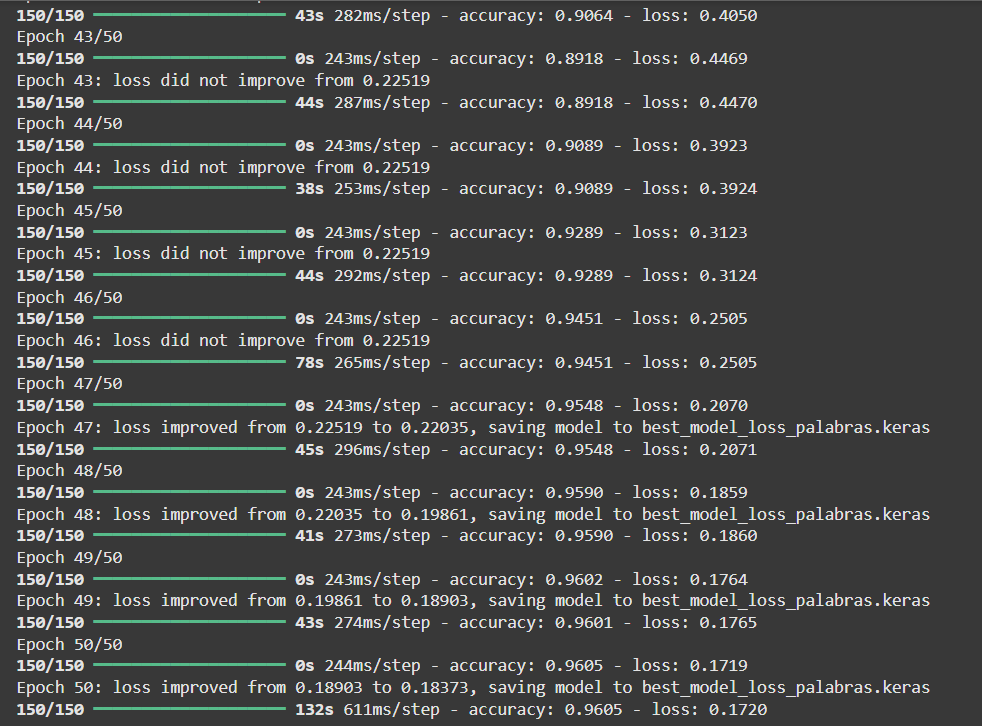

In [59]:
'''
acc = history.history['accuracy']
loss = history.history['loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 4))

# Gráfico de Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.legend(loc='lower right')
plt.title('Training Accuracy')

# Gráfico de Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.legend(loc='upper right')
plt.title('Training Loss')

plt.show()
'''

"\nacc = history.history['accuracy']\nloss = history.history['loss']\n\nepochs_range = range(EPOCHS)\n\nplt.figure(figsize=(8, 4))\n\n# Gráfico de Accuracy\nplt.subplot(1, 2, 1)\nplt.plot(epochs_range, acc, label='Training Accuracy')\nplt.legend(loc='lower right')\nplt.title('Training Accuracy')\n\n# Gráfico de Loss\nplt.subplot(1, 2, 2)\nplt.plot(epochs_range, loss, label='Training Loss')\nplt.legend(loc='upper right')\nplt.title('Training Loss')\n\nplt.show()\n"

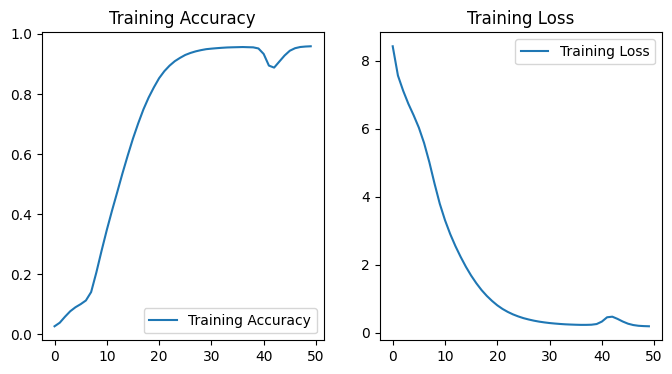

In [60]:
# Load the best model
best_model_palabras = load_model('best_model_loss_palabras.keras')
print("Best model loaded successfully!")

Best model loaded successfully!


## Generación de texto palabra a palabra

In [61]:
def generate_text(model, start_string, lookup_layer, reverse_lookup_layer, num_generate=5, temperature=1.0):
    """
    Generar texto basado en un modelo secuencial entrenado para palabras.

    Args:
    - model: El modelo entrenado y cargado.
    - start_string: Cadena inicial para comenzar la generación de texto.
    - lookup_layer: Capa `StringLookup` para convertir palabras en índices.
    - reverse_lookup_layer: Capa inversa para convertir índices en palabras.
    - num_generate: Número de palabras a generar.
    - temperature: Controla la aleatoriedad de las predicciones (más alto, más aleatorio).

    Returns:
    - Texto generado.
    """
    # Dividir la cadena inicial en palabras y convertirlas a índices
    input_eval = tf.strings.split([start_string])  # Dividir en palabras
    input_eval = lookup_layer(input_eval)  # Convertir palabras a índices

    # Ajustar dimensiones para que coincidan con las esperadas por el modelo
    input_eval = tf.squeeze(input_eval, axis=0)  # Eliminar dimensión extra
    input_eval = tf.expand_dims(input_eval, axis=0)  # Añadir batch dimension

    # Lista para almacenar las palabras generadas
    words_generated = []

    # Generar palabras
    for _ in range(num_generate):
        # Obtener predicción
        predictions = model(input_eval)  # Obtener predicciones del modelo
        predictions = predictions[:, -1, :] / temperature  # Usar la última predicción

        # Elegir el siguiente índice basado en la distribución de probabilidades
        predicted_id = tf.random.categorical(predictions, num_samples=1)[0, 0].numpy()

        # Convertir el índice a una palabra
        next_word = reverse_lookup_layer(predicted_id).numpy().decode('utf-8')

        # Agregar la palabra generada a la lista
        words_generated.append(next_word)

        # Actualizar `input_eval` con el nuevo índice
        input_eval = tf.concat([input_eval, [[predicted_id]]], axis=1)

    # Concatenar palabras generadas en un texto
    return start_string + ' ' + ' '.join(words_generated)





In [62]:
start_text = "To die: to sleep; To sleep:"
#start_text = "What is the meaning of being"
#start_text = "to be or not to be"
#start_text = "Death shall have no dominion"
generated_text = generate_text(
    best_model_palabras,  # Modelo previamente cargado
    start_text,  # Cadena inicial
    lookup_layer,  # Capa para convertir palabras a índices
    reverse_lookup_layer,  # Capa para convertir índices a palabras
    num_generate=6,  # Número de palabras a generar
    temperature=0.2  # Nivel de aleatoriedad
)

print("Texto generado:\n", generated_text)

Texto generado:
 To die: to sleep; To sleep: I will be there to say


El modelo genera texto de modo coherente y parece copiar el estilo de Shakespare

# CONCLUSIONES

El modelo de predicción basado en palabras tiene una prefomance muy superior al basado en caracteres. Consideramos que esto se debe a que el primero se condice con la unidad mínima de sentido para el hablante, la palabra, y de este modo se correlaciona mejor con las relaciones lingüísticas. De modo contrario, una letra o un conjutno menor a la palabra de ellas, no tiene un significado evidente para el hablante. Esto hace que la combinación que se produce en la predicción tenga mucho más sentido al nivel de palabras, porque una palabra "errada" seguiría aportando sentido o algo de sentido, mientra que una letra equivocada arrastraría un error que genera palabras que no existen y no tienen nada de sentido. Pensemos en un ejemplo donde el modelo se equivoca y genera apartir de "agua", la seguiente palabra: "seca". "Agua seca", podríamos pensar, no tiene sentido alguno. Ahora bien, esta contradicción es un oxímoron y se utiliza a menudo como figura retórico o poética, y puede servir en un texto para referise metafóficamente al granizo.

Más allá de esta gran diferencia, ambos modelos funcionan mejor cuando la temeratura es cercana a 0, es decir, al ser más determinísticos. En el caso del modelo caracter a caracter, al menos de este modo produce palabras que existen, aunque las repite; si uno aumenta la temperatura, comienza a generar agrupaciones de caracteres sin sentido. En el caso del modelo palabra a palabra, al ser más determinísito, en nuestra opinión, produce un texto con más sentido y más fiel al estilo del autor; si uno aumenta la temperatura, al ser más "creativo", también genera sin sentidos. Otra cuestión en que tienen una performance comparable es en la extensión de la predicción. Para el caso de caracter a catacter, por más determinístico sea el modelo, si se aumenta la extensión de predicción, comienza a generar palabras inexistentes. En el caso del de palabra a palabra, cuanto mayor es la extensión se va desvaneciendo el sentido. Esto se relación con la falta de memoria a largo plazo de las rededes neuronales recurrentes: a medida que la distancia aumenta, la incidencia de las palabras introducidas para que el modelo prediga, cada vez tienen menos incidencia en la próxima a generar.